## Dependencies

In [1]:
import io
import re
import string
import tqdm
import glob

import numpy as np

import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
CURRENTYEAR=2023

# Data Preproccessing

In [4]:
path_to_dir = f'../../datasets/gameRecaps/{CURRENTYEAR}/'


In [5]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [6]:

all_files = glob.glob(f'{path_to_dir}/**/*txt', recursive=True)

text_ds = tf.data.TextLineDataset(all_files).filter(lambda x: tf.cast(tf.strings.length(x), bool))


### Vectorize sentences from the corpus

In [7]:
# create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)


vectorize_layer.adapt(text_ds.batch(1024))
inverse_vocab = vectorize_layer.get_vocabulary()

text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())



In [8]:
### OPTIONAL
for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 243 1652  464  199 1735  386  192    6   84  226] => ['love', 'clifford', 'help', 'packers', 'roll', 'past', 'bengals', 'in', 'preseason', 'opener']
[ 232  541  434 1714  260  297 1142 1463    6 3071] => ['colts', 'qb', 'richardson', 'struggles', 'bills', 'safety', 'hamlin', 'shines', 'in', 'buffalos']
[2823  269  561   77  896  601 1529  120   65   74] => ['qbs', 'watson', 'howell', 'have', 'solid', 'starts', 'brissett', 'has', 'td', 'run']
[   1 3120  350  129   65 1780  185    4    3 1687] => ['[UNK]', '79yard', 'punt', 'return', 'td', 'helps', 'falcons', 'to', 'a', '193']
[ 165  896   32    3  263   32  144 1836  433 1411] => ['wilson', 'solid', 'as', 'a', 'backup', 'as', 'jets', 'begin', 'rodgers', 'era']


## Generate training examples

In [9]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=15,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 160/160 [00:00<00:00, 414.22it/s]



targets.shape: (724,)
contexts.shape: (724, 16)
labels.shape: (724, 16)


In [10]:
print(tf.shape(targets))
print(tf.shape(contexts))
print(tf.shape(labels))

BATCH_SIZE = 238
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

num_batches = dataset.cardinality().numpy()
print(num_batches)

tf.Tensor([724], shape=(1,), dtype=int32)
tf.Tensor([724  16], shape=(2,), dtype=int32)
tf.Tensor([724  16], shape=(2,), dtype=int32)
3


## Model and training

In [11]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=15+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [12]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [13]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [15]:
word2vec.fit(dataset, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100


3/3 [==============================] - 1s 25ms/step - loss: 2.7731 - accuracy: 0.0658
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 2.7651 - accuracy: 0.2577
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 2.7579 - accuracy: 0.4300
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 2.7505 - accuracy: 0.6092
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 2.7430 - accuracy: 0.7521
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 2.7350 - accuracy: 0.8431
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 2.7268 - accuracy: 0.8894
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 2.7177 - accuracy: 0.9174
Epoch 9/100
3/3 [==============================] - 0s 23ms/step - loss: 2.7081 - accuracy: 0.9244
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 2.6978 - accuracy: 0.9314
Epoch 11/100
3/3 [=============

In [16]:
def retreieve(word):
    def word_to_index(word):
        try:
            return inverse_vocab.index(word)
        except ValueError:
            return None

    word_index = word_to_index(word)
    if word_index is None:
        print(f"Word '{word}' not found in vocabulary!")
        return None

    word_vector = word2vec.target_embedding(tf.constant([[word_index]]))
    return tf.squeeze(word_vector, axis=0).numpy()


## Visualization

In [17]:
def plot_pca_reduction(vectors, labels):
    """
    Reduces the dimensionality of the given vectors to 2 using PCA and plots them.
    
    Args:
    - vectors (list of list of float): The list of vectors to reduce and plot.
    - labels (list of str): Names corresponding to each vector.
    
    Returns:
    None
    """
    # Convert the list of vectors to a numpy array
    vectors = np.array(vectors)

    # Initialize PCA and reduce dimensionality to 2
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # Extract the 2D coordinates
    x_coords = reduced_vectors[:, 0]
    y_coords = reduced_vectors[:, 1]

    # Plot the 2D representation of the vectors
    plt.scatter(x_coords, y_coords)
    
    # Add labels above each point
    for x, y, label in zip(x_coords, y_coords, labels):
        plt.text(x, y, label, fontsize=9, ha='center', va='bottom')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Reduced Vectors')
    plt.show()

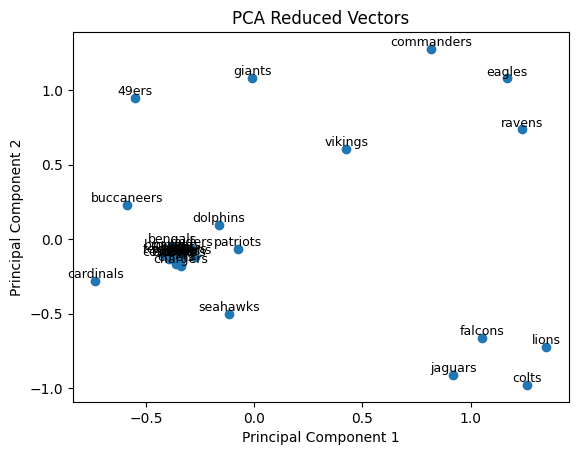

In [18]:
nfl_teams = [
    "cardinals",
    "falcons",
    "ravens",
    "bills",
    "panthers",
    "bears",
    "bengals",
    "browns",
    "cowboys",
    "broncos",
    "lions",
    "packers",
    "texans",
    "colts",
    "jaguars",
    "chiefs",
    "chargers",
    "rams",
    "dolphins",
    "vikings",
    "patriots",
    "saints",
    "giants",
    "jets",
    "raiders",
    "eagles",
    "steelers",
    "49ers",
    "seahawks",
    "buccaneers",
    "titans",
    "commanders"]

vecs = list(map(retreieve, nfl_teams))
vecs = list(map(np.squeeze, vecs))

plot_pca_reduction(vecs, nfl_teams)

In [19]:
import os

def write_to_tsv(data, filename):
    """
    Write a list of lists to a TSV file.

    :param data: List of lists containing the data
    :param filename: Name of the TSV file to write to
    """
    # Check if the directory exists, if not, create it
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(filename, 'w') as f:
        for row in data:
            f.write('\t'.join(map(str, row)))
            f.write('\n')

if len(nfl_teams) != len(vecs):
    raise ValueError("Both input lists must have the same length.")

data = []
for team, array in zip(nfl_teams, vecs):
    modified_array = [team] + array.tolist()
    data.append(modified_array)

write_to_tsv(data, f'../vecs/{CURRENTYEAR}/commanders.tsv')



## Embedding lookup and analysis

In [20]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [21]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [22]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass